# Eval Diffusion Model
### Imports

In [6]:
try: 
    import librosa
except:
    !pip install librosa

#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))
# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import conf

### Conf

In [7]:
remote_kernel: bool = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name: str = "diffusion_v20_1_epoch_160"
training_data_name: str = "training_full_low_res"
model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Functions

In [8]:
def bwd_pass(model: Diffusion, n_samples: int = 1, file_name: str = "test") -> None:
    x: ndarray = model.bwd_diffusion(n_samples=n_samples)
    print(x[0,0].shape)
    for i in range(x.shape[0]):
        logger.info(f"Sample {i}")
        visualize_spectogram(x[i, 0])
        audio = spectrogram_to_audio(unnormalize(x[i, 0]), conf["audio"].len_fft)
        save_audio_file(audio, path_to_remote_path("{}/{}".format(conf["paths"].result_path, f"{file_name}_{i:02d}_out.wav"), remote_kernel))
    logger.light_debug("Saved passed through samples to {}".format(conf["paths"].result_path))



def print_eval_metrics(data: ndarray) -> None:
    if data.ndim == 2:
        data = np.expand_dims(data, axis = 0)
    for i, sample in enumerate(data):
        sc_score = spectral_convergence(sample, len_fft=conf["audio"].len_fft, hop_length=conf["audio"].len_hop, sample_rate=conf["audio"].sample_rate)
        sdr_score = sdr(sample, sample_rate=conf["audio"].sample_rate, cutoff=4000)
        print(f"Sample {(i + 1):02d} Spectral Convergence: {sc_score:.4f} SDR score: {sdr_score:.2f} dB")


### Data Loading & Model Creation

In [9]:
file = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:100,...]
logger.info(f"Data loaded with shape: {file.shape}")

u_net = Conv_U_NET(in_channels=1,
                    time_embed_dim=conf["model"].time_embed_dim, 
                    n_starting_filters=conf["model"].n_starting_filters, 
                    n_downsamples=conf["model"].n_downsamples, 
                    activation=nn.GELU(), 
                    device=device,
                    conditional_norm=False
                ).to(device)

if os.path.exists(model_path):
    u_net.load_state_dict(torch.load(model_path, map_location=device)["model"])
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else:
    raise AssertionError(f"No Model with {model_name} found!")

diffusion = Diffusion(model=u_net, 
                        noise_steps=conf["model"].diffusion_timesteps, 
                        noise_schedule="cosine", 
                        input_dim=[conf["model"].batch_size, 1, file.shape[-2], file.shape[-1]],
                        device=device
                    )


2025-03-28 09:54:01,160 - LIGHT_DEBUG - Ndarray loaded from Data/training_full_low_res.npy of shape: (7087, 224, 416)
2025-03-28 09:54:01,169 - INFO - Data loaded with shape: (100, 224, 416)
2025-03-28 09:54:02,634 - INFO - Model diffusion_v20_1_epoch_160 loaded with 26981881 Parameters


### Evaluate

2025-03-28 09:54:02,743 - INFO - Started sampling 8 samples


2025-03-28 09:54:38,000 - LIGHT_DEBUG - Sampling timestep 100/1000 X min/max: -5.00678, 3.63022 noise min/max: -5.00223, 4.25906 std/mean: 1.00306, -0.25821 

2025-03-28 09:54:38,870 - LIGHT_DEBUG - Normalized to range: [-1,1]


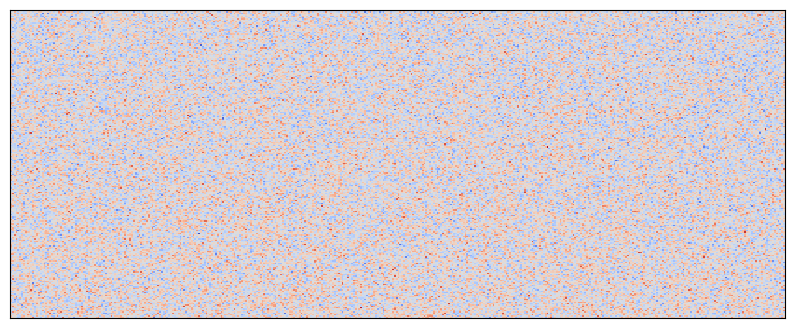

2025-03-28 09:55:14,000 - LIGHT_DEBUG - Sampling timestep 200/1000 X min/max: -4.74577, 3.68215 noise min/max: -4.91699, 4.44678 std/mean: 0.98622, -0.27375 

2025-03-28 09:55:15,112 - LIGHT_DEBUG - Normalized to range: [-1,1]


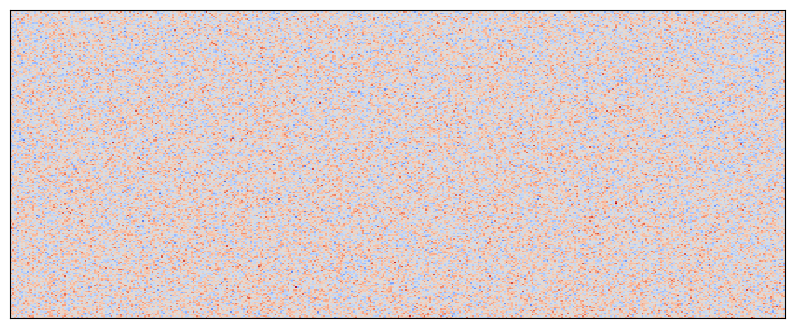

2025-03-28 09:55:50,000 - LIGHT_DEBUG - Sampling timestep 300/1000 X min/max: -4.66287, 3.85204 noise min/max: -4.90747, 4.85933 std/mean: 0.96132, -0.24192 

2025-03-28 09:55:51,338 - LIGHT_DEBUG - Normalized to range: [-1,1]


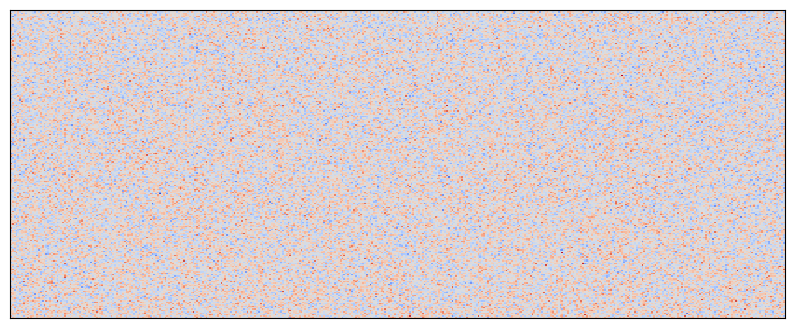

2025-03-28 09:56:26,000 - LIGHT_DEBUG - Sampling timestep 400/1000 X min/max: -4.23024, 3.20869 noise min/max: -4.55089, 3.96670 std/mean: 0.92928, -0.19209 

2025-03-28 09:56:27,006 - LIGHT_DEBUG - Normalized to range: [-1,1]


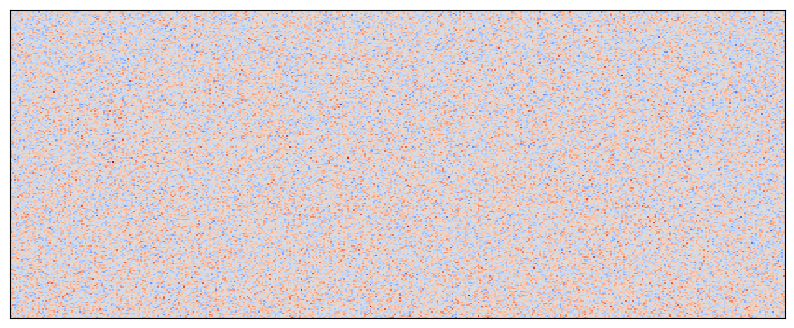

2025-03-28 09:57:02,000 - LIGHT_DEBUG - Sampling timestep 500/1000 X min/max: -4.05480, 2.93466 noise min/max: -4.30965, 3.99577 std/mean: 0.89227, -0.16058 

2025-03-28 09:57:03,219 - LIGHT_DEBUG - Normalized to range: [-1,1]


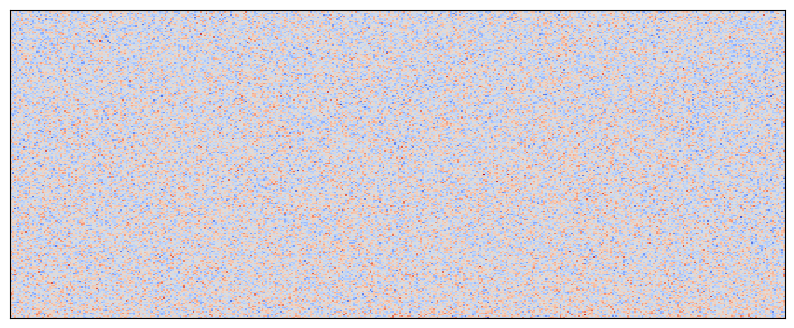

2025-03-28 09:57:39,000 - LIGHT_DEBUG - Sampling timestep 600/1000 X min/max: -3.89163, 2.33735 noise min/max: -4.66550, 3.81383 std/mean: 0.84619, -0.10838 

2025-03-28 09:57:39,332 - LIGHT_DEBUG - Normalized to range: [-1,1]


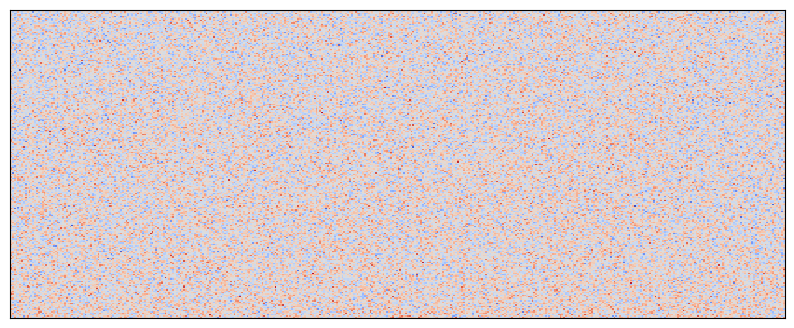

2025-03-28 09:58:15,000 - LIGHT_DEBUG - Sampling timestep 700/1000 X min/max: -3.29602, 1.92263 noise min/max: -3.69071, 3.77059 std/mean: 0.78036, -0.07599 

2025-03-28 09:58:15,607 - LIGHT_DEBUG - Normalized to range: [-1,1]


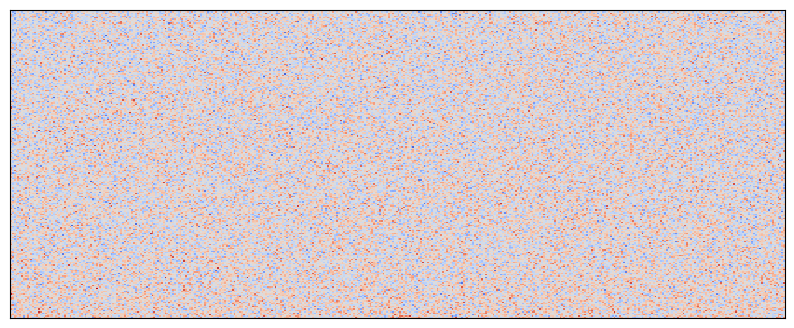

2025-03-28 09:58:51,000 - LIGHT_DEBUG - Sampling timestep 800/1000 X min/max: -2.93174, 1.61379 noise min/max: -3.63221, 3.58367 std/mean: 0.70274, -0.07808 

2025-03-28 09:58:51,779 - LIGHT_DEBUG - Normalized to range: [-1,1]


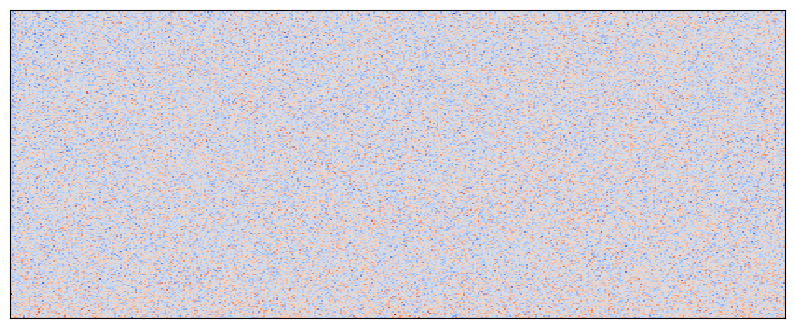

2025-03-28 09:59:27,000 - LIGHT_DEBUG - Sampling timestep 900/1000 X min/max: -2.62546, 1.08349 noise min/max: -3.34432, 3.52716 std/mean: 0.62585, -0.03738 

2025-03-28 09:59:27,862 - LIGHT_DEBUG - Normalized to range: [-1,1]


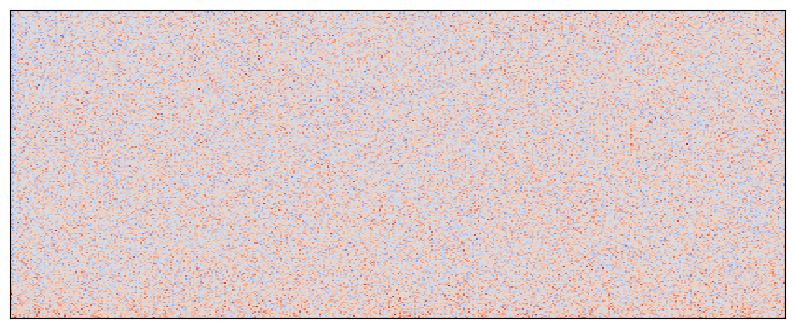

2025-03-28 10:00:03,000 - LIGHT_DEBUG - Sampling timestep 999/1000 X min/max: -2.22090, 0.81523 noise min/max: -1.78087, 1.80335 std/mean: 0.34675, 0.07761  


2025-03-28 10:00:03,557 - LIGHT_DEBUG - Final X min/max before return: -2.22090, 0.81523
2025-03-28 10:00:03,557 - INFO - Created 8 samples


In [10]:
#bwd_pass(diffusion, n_samples=8, file_name="test")
#x: ndarray = diffusion.bwd_diffusion_ddim(n_samples=8, sampling_timesteps=100, eta = 0.0)
x: ndarray = diffusion.bwd_diffusion_ddpm(n_samples=8, visual_freq=100)

-2.0374177 0.4935232


2025-03-28 10:00:03,701 - LIGHT_DEBUG - Normalized to range: [-1,1]


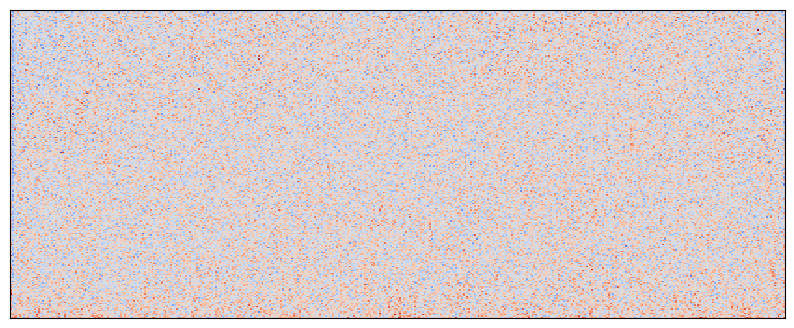

-2.1395435 0.62272465


2025-03-28 10:00:03,868 - LIGHT_DEBUG - Normalized to range: [-1,1]


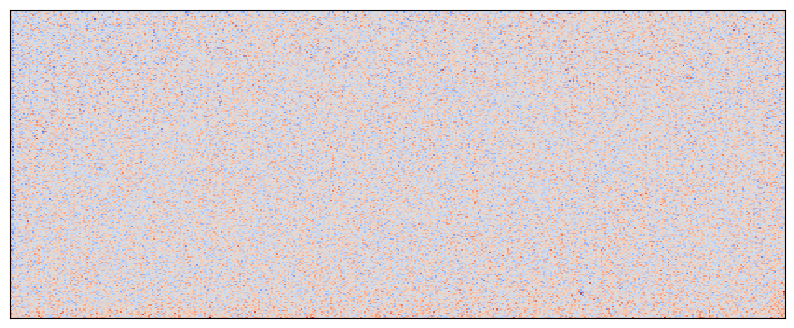

-2.0519156 0.5233821


2025-03-28 10:00:04,022 - LIGHT_DEBUG - Normalized to range: [-1,1]


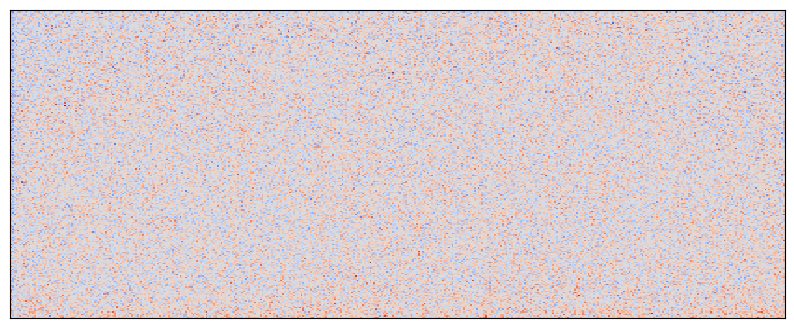

-2.0200417 0.8152272


2025-03-28 10:00:04,180 - LIGHT_DEBUG - Normalized to range: [-1,1]


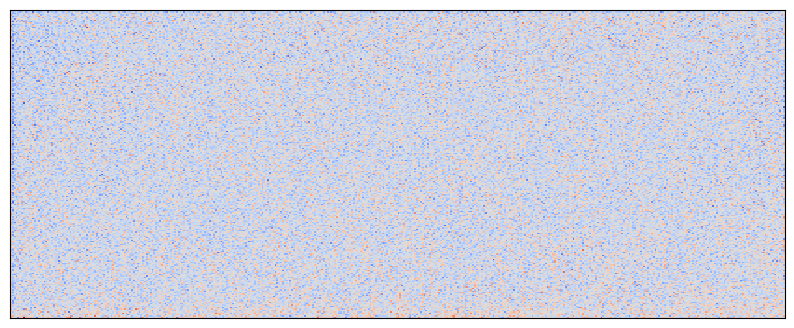

-2.1365855 0.4789465


2025-03-28 10:00:04,345 - LIGHT_DEBUG - Normalized to range: [-1,1]


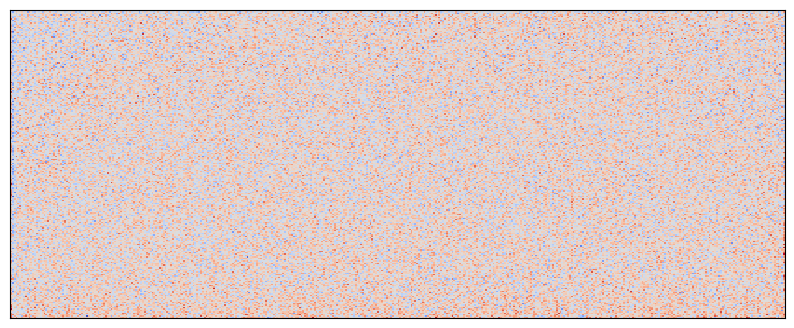

-2.1369212 0.5465181


2025-03-28 10:00:04,502 - LIGHT_DEBUG - Normalized to range: [-1,1]


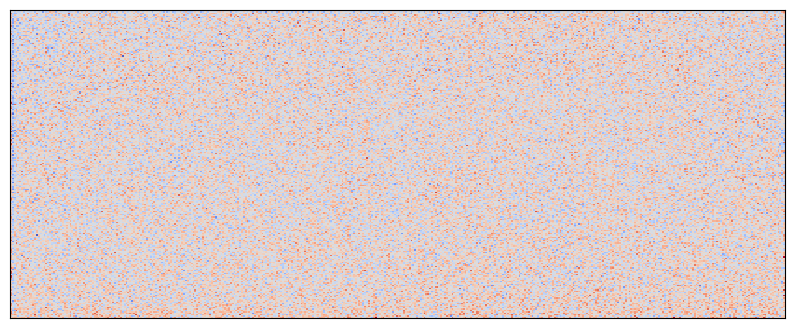

-2.0561516 0.4674164


2025-03-28 10:00:04,657 - LIGHT_DEBUG - Normalized to range: [-1,1]


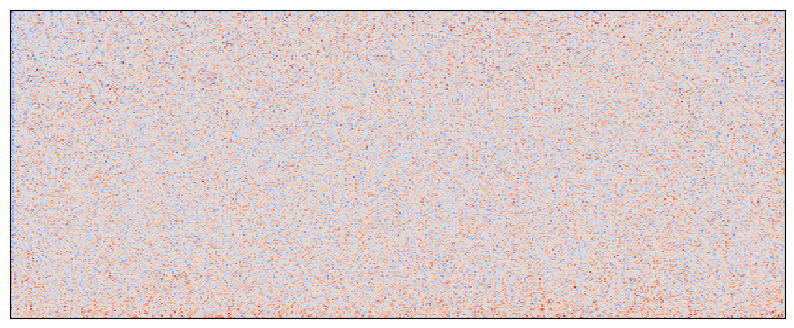

-2.220897 0.5602396


2025-03-28 10:00:04,815 - LIGHT_DEBUG - Normalized to range: [-1,1]


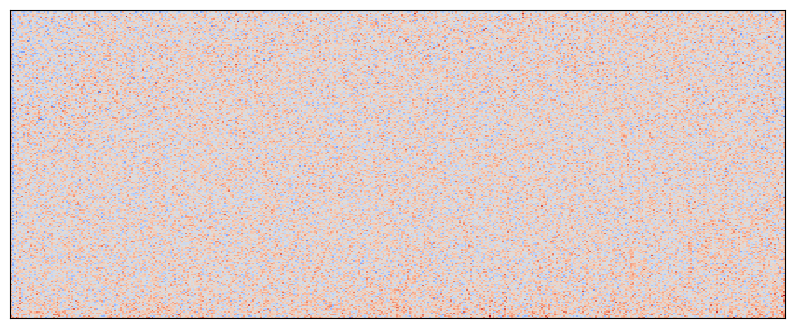

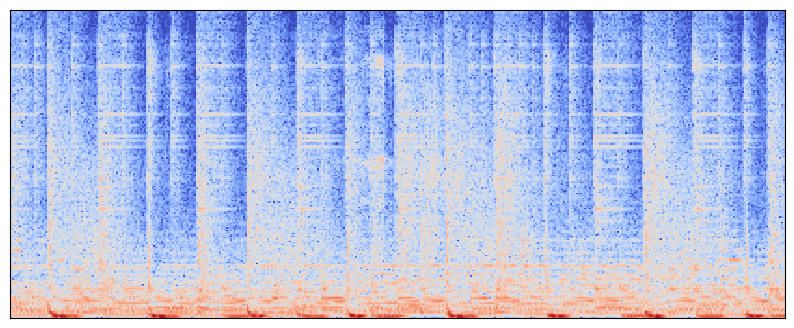

In [11]:
#print_eval_metrics(x)
for i in range(x.shape[0]):
    print(np.min(x[i,0]), np.max(x[i,0]), flush=True)
    visualize_spectogram(normalize(x[i,0], -1, 1))
#save_audio_file(spectrogram_to_audio(unnormalize(x[0,0]), conf["audio"].len_fft, conf["audio"].len_hop), path_to_remote_path("{}/{}".format(conf["paths"].result_path, "test.wav"), remote_kernel), conf["audio"].sample_rate)
visualize_spectogram(file[99])


### Save Model Architecture

In [12]:
u_net.eval()
with torch.no_grad():
    u_net.eval()
with torch.no_grad():
    example_x = torch.randn(8, 1, file.shape[-2], file.shape[-1]).to(device)
    example_t = torch.randint(0, 500, (8,), dtype=torch.long).to(device)

    script_model = torch.jit.trace(u_net,(example_x, example_t), check_trace=False)
torch.jit.save(script_model, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))
#torchviz.make_dot(model(torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1])), params=dict(model.named_parameters())).render(f"{RESULT_PATH}/{model_name}", format="png") #Not working
#logger.info(f"Saved model {path_to_remote_path(f"{RESULT_PATH}/{model_name}.pt", remote_kernel)}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 228.00 MiB. GPU 0 has a total capacty of 15.73 GiB of which 120.56 MiB is free. Process 1923111 has 14.13 GiB memory in use. Process 2208703 has 1.48 GiB memory in use. Of the allocated memory 1.04 GiB is allocated by PyTorch, and 297.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF